<center><h1>Replication Prototype – Duopoly Setting</h1></center>

In [2]:
# Standard library
import nest_asyncio
import asyncio
import json
import os
import sys
import warnings

sys.path.append(os.path.abspath(os.path.join("../..")))

# Apply third-party setup
nest_asyncio.apply()

# Third-party libraries
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Local application imports
from utils.prompts import GENERAL_PROMPT, P1, P2
from utils.pricing_market_logic_multiproduct import (
    get_monopoly_prices,
    get_nash_prices,
    get_profits,
    get_quantities,
)
from utils.utils import (
    create_output_paths,
    make_df_from_results,
    plot_duopoly_results_from_df,
    save_round_data,
    simulate_n_firms_round,
    update_plot_duopoloy,
)

# Load environment variables
load_dotenv()

# Configuration
API_KEY = os.getenv("MISTRAL_API_KEY")
MODEL_NAME = "magistral-small-2506"  # Free open-source model
# MODEL_NAME = "mistral-medium-latest" # mistral-medium-2505

# Optional: Ignore specific warning types
warnings.filterwarnings("ignore", category=SyntaxWarning)

# Experiments
---

In total they run 42 experiments:
 - 21 using P1, where:
    - 7 where using $\alpha=1$
    - 7 where using $\alpha=3.2$
    - 7 where using $\alpha=10$
 - 21 using P2, where:
    - 7 where using $\alpha=1$
    - 7 where using $\alpha=3.2$
    - 7 where using $\alpha=10$

In [ ]:
N_FIRMS = 2
MARGINAL_COST = 1.0
N_PERIODS = 300
N_ROUNDS = 3
for PROMPT_NUMBER, PROMPT_PREFIX in enumerate([P1, P2], start=1):
    for ALPHA in [1, 3.2, 10]:
        a0 = 0.0
        a = tuple([2.0 for _ in range(N_FIRMS)])
        mu = 0.25
        alpha = tuple([ALPHA for _ in range(N_FIRMS)])
        c = tuple([MARGINAL_COST for _ in range(N_FIRMS)])
        beta = 100
        sigma = 0.25 # critical: this disables nesting → standard logit
        group_idxs = tuple([i for i in range(1, N_FIRMS+1)])
        WILLIWGNES_TO_PAY = 4.51 * ALPHA

        monopoly_prices = get_monopoly_prices(
            a0=a0,
            a=a,
            mu=mu,
            alpha=alpha,
            c=c,
            multiplier=beta,
            sigma=sigma,
            group_idxs=group_idxs,
        )
        nash_prices = get_nash_prices(
            a0=a0,
            a=a,
            mu=mu,
            alpha=alpha,
            multiplier=beta,
            sigma=sigma,
            group_idxs=group_idxs,
            c=c,
        )

        monopoly_q = get_quantities(
            p=tuple(monopoly_prices),
            a0=a0,
            a=a,
            mu=mu,
            alpha=alpha,
            multiplier=beta,
            sigma=sigma,
            group_idxs=group_idxs,
        )

        monopoly_profits = get_profits(
            p=tuple(monopoly_prices),
            c=c,
            a0=a0,
            a=a,
            mu=mu,
            alpha=alpha,
            multiplier=beta,
            sigma=sigma,
            group_idxs=group_idxs,
        )
        print(f"Monopoly prices: {monopoly_prices} | Nash prices: {nash_prices}")
        print(f"Monopoly profits: {monopoly_profits} | Monopoly quantities: {monopoly_q}")

        for _ in range(N_ROUNDS):
            p_m = monopoly_prices[0]
            q_m = monopoly_q[0]
            pi_m = monopoly_profits[0]
            firm_names = [f"firm_{i+1}" for i in range(N_FIRMS)]
            sub_path = f"duopoly/prompt_{PROMPT_NUMBER}-alpha_{int(ALPHA)}"
            paths = create_output_paths(sub_path=sub_path, 
                                        model_name=MODEL_NAME, 
                                        firm_names=firm_names
                                        )

            plans = {firm: "No previous plans." for firm in firm_names}
            insights = {firm: "No previous insights." for firm in firm_names}
            market_data = {firm: "No previous market data." for firm in firm_names}

            # Initialize the market data file
            experiment_results={'price_history': {k:[] for k in firm_names},
                                'quantity_history': {k:[] for k in firm_names},
                                'profit_history': {k:[] for k in firm_names},
                                'time_history': [],
                                }

            fig = plt.figure(figsize=(14, 10))
            gs = gridspec.GridSpec(3, 2, width_ratios=[2, 1], height_ratios=[1, 1, 1])

            # Create the 5 axes: 3 time series on the left, 2 plots on the right
            axs = [
                fig.add_subplot(gs[0, 0]),  # Price time series
                fig.add_subplot(gs[1, 0]),  # Quantity time series
                fig.add_subplot(gs[2, 0]),  # Profit time series
                fig.add_subplot(gs[0:2, 1]),  # Price trajectory (spans two rows)
                fig.add_subplot(gs[2, 1]),  # Profit trajectory
            ]


            for i in range(1, N_PERIODS+1):
                
                # 1) Generate dict with prompts per firm
                agent_prompt_dict = {firm_name: {'prompt':GENERAL_PROMPT.format(
                                                                marginal_cost=MARGINAL_COST,
                                                                willigness_to_pay=WILLIWGNES_TO_PAY,
                                                                previous_plans = plans[firm_name],
                                                                previous_insights = insights[firm_name],
                                                                market_data = market_data[firm_name]
                                                                ),
                                                'prefix': PROMPT_PREFIX,
                                                }
                                    
                                    for firm_name in firm_names}
                
                #Firms act simultaneously (async prompts)
                results = asyncio.run(simulate_n_firms_round(agent_prompt_dict))
                firm_responses = {result['firm']: result['response'] for result in results}
                
                #Get chosen prices
                prices = [firm_responses[firm]['chosen_price'] for firm in firm_names]

                # Compute quantities and profits for each firm, based on the chosen prices
                quantities = get_quantities(
                                    p=tuple(prices),
                                    a0=a0,
                                    a=a,
                                    mu=mu,
                                    alpha=alpha,
                                    multiplier=beta,
                                    sigma=sigma,
                                    group_idxs=group_idxs,
                                )
                profits = get_profits(
                                    p=tuple(prices),
                                    c=c,
                                    a0=a0,
                                    a=a,
                                    mu=mu,
                                    alpha=alpha,
                                    multiplier=beta,
                                    sigma=sigma,
                                    group_idxs=group_idxs,
                                )
                # Save the results for each firm
                for firm in firm_names:
                    experiment_results['price_history'][firm].append(prices[firm_names.index(firm)])
                    experiment_results['quantity_history'][firm].append(quantities[firm_names.index(firm)])
                    experiment_results['profit_history'][firm].append(profits[firm_names.index(firm)])

                experiment_results['time_history'].append(i)

                # Save responses + logs
                firm_responses = save_round_data(i, paths, firm_responses, prices, quantities, profits, firm_names)

                # Update prompt components
                plans = {firm: {firm_responses[firm]['plans']} for firm in firm_names}
                insights = {firm: {firm_responses[firm]['insights']} for firm in firm_names}
                market_data = {firm: firm_responses[firm]['last_market_data'] for firm in firm_names}

                update_plot_duopoloy(
                    fig, axs,
                    p_m=p_m, q_m=q_m, pi_m=pi_m, alpha=ALPHA, nash_price = nash_prices[0],
                    price_history=experiment_results["price_history"],
                    quantity_history=experiment_results["quantity_history"],
                    profit_history=experiment_results["profit_history"],
                    time_history=experiment_results["time_history"],
                    model_name=MODEL_NAME,
                    start_time=paths["start_time"],
                    save_path=paths["plot"] + f"/{i:03d}_experiment_round.png",
                    prompt_number=PROMPT_NUMBER
                )


            # Turn off interactive plotting and show final plot
            plt.close(fig)

            # Save the final results to a JSON file
            with open(paths["output_dir"] + "/results.json", 'w') as f:
                json.dump(experiment_results, f, indent=4)

# Results
---

In [3]:
df_res = make_df_from_results(results_path="results/duopoly",
                              model_name=MODEL_NAME
                              )
df_res

,prompt,alpha,experiment,p1,p2,pi_1,pi_2,pi_delta
0,2,1.0,2025-06-15_10-58_experiment_magistral-small-2506,1.441000,1.395000,18.726844,20.266999,-1.540156
1,2,1.0,2025-06-15_11-21_experiment_magistral-small-2506,1.404600,1.451000,20.670778,18.620454,2.050324
2,2,1.0,2025-06-15_18-58_experiment_magistral-small-2506,1.442000,1.433000,20.307477,20.503386,-0.195909
3,2,1.0,2025-06-15_19-44_experiment_magistral-small-2506,1.395000,1.354000,17.192449,18.129456,-0.937007
4,2,1.0,2025-06-15_19-20_experiment_magistral-small-2506,1.410000,1.446000,20.567127,19.418348,1.148779
5,2,1.0,2025-06-15_18-31_experiment_magistral-small-2506,1.444400,1.426000,20.035644,20.619090,-0.583446
6,2,1.0,2025-06-15_17-59_experiment_magistral-small-2506,1.435000,1.459000,20.627753,20.141225,0.486528
7,2,1.0,2025-06-15_11-43_experiment_magistral-small-2506,1.452600,1.454800,20.583408,20.648919,-0.065511
8,1,1.0,2025-06-15_02-16_experiment_magistral-small-2506,1.698000,1.650000,27.022195,30.496219,-3.474024
9,1,1.0,2025-06-14_19-38_experiment_magistral-small-2506,1.361000,1.403000,18.677179,17.691578,0.985601


In [4]:
N_FIRMS = 2
ALPHA = 1
MARGINAL_COST = 1.0
a0 = 0.0
a = tuple([2.0 for _ in range(N_FIRMS)])
mu = 0.25
alpha = tuple([ALPHA for _ in range(N_FIRMS)])
c = tuple([MARGINAL_COST for _ in range(N_FIRMS)])
beta = 100
sigma = 0.0  # critical: this disables nesting → standard logit
group_idxs = tuple([i for i in range(1, N_FIRMS+1)])
WILLIWGNES_TO_PAY = 4.51 * ALPHA

monopoly_prices = get_monopoly_prices(
    a0=a0,
    a=a,
    mu=mu,
    alpha=alpha,
    c=c,
    multiplier=beta,
    sigma=sigma,
    group_idxs=group_idxs,
)
nash_prices = get_nash_prices(
    a0=a0,
    a=a,
    mu=mu,
    alpha=alpha,
    multiplier=beta,
    sigma=sigma,
    group_idxs=group_idxs,
    c=c,
)

nash_profits = get_profits(
    p=tuple(nash_prices),
    c=c,
    a0=a0,
    a=a,
    mu=mu,
    alpha=alpha,
    multiplier=beta,
    sigma=sigma,
    group_idxs=group_idxs,
)

monopoly_q = get_quantities(
    p=tuple(monopoly_prices),
    a0=a0,
    a=a,
    mu=mu,
    alpha=alpha,
    multiplier=beta,
    sigma=sigma,
    group_idxs=group_idxs,
)

monopoly_profits = get_profits(
    p=tuple(monopoly_prices),
    c=c,
    a0=a0,
    a=a,
    mu=mu,
    alpha=alpha,
    multiplier=beta,
    sigma=sigma,
    group_idxs=group_idxs,
)

pi_m = monopoly_profits[0]
pi_nash = nash_profits[0]
p_nash = nash_prices[0]
p_m = monopoly_prices[0]


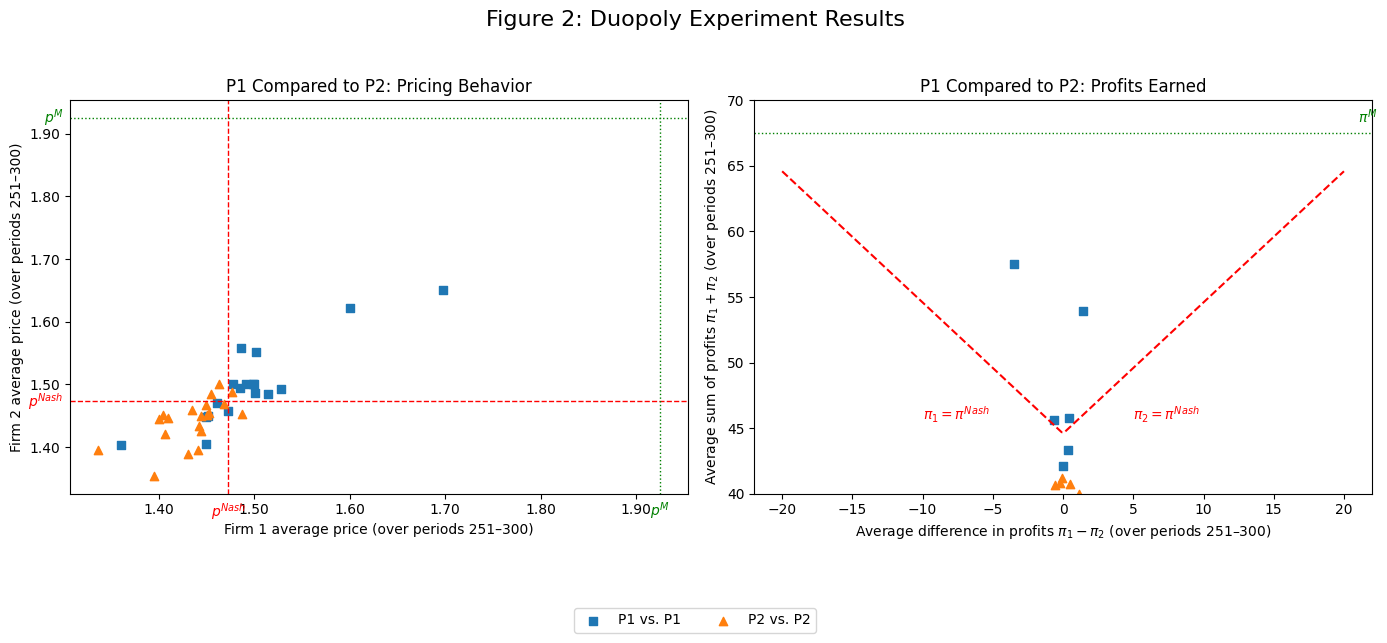

In [5]:
plot_duopoly_results_from_df(
    df=df_res,
    p_nash=p_nash,
    p_m=p_m,
    pi_nash=pi_nash,
    pi_m=(pi_m*2),
    title="Figure 2: Duopoly Experiment Results"
)


In [6]:
quantities = get_quantities(
                    p=tuple([1.5, 2.76]),
                    a0=a0,
                    a=a,
                    mu=mu,
                    alpha=alpha,
                    multiplier=beta,
                    sigma=sigma,
                    group_idxs=group_idxs,
                )
profits = get_profits(
                    p=tuple([1.5, 2.76]),
                    c=c,
                    a0=a0,
                    a=a,
                    mu=mu,
                    alpha=alpha,
                    multiplier=beta,
                    sigma=sigma,
                    group_idxs=group_idxs,
                )
print("Quantities:", quantities)
print("Profits:", profits)

Quantities: [87.58031968254899, 0.5669729472601505]
Profits: [43.790159841274495, 0.9978723871778646]
